# ESPEI

### Extensible Self-optimizating Phase Equilibria Infrastructure

Documentation for internal and external APIs can be found at https://espei.org


## Markov Chain Monte Carlo (MCMC)

### Running MCMC

The most minimal MCMC settings file that could be used for ESPEI only requires setting the source of the database (i.e. the database from parameter selection) and the number of iterations.

```yaml
system:
  phase_models: phases.json
  datasets: input-data/run
output:
  output_db:  mcmc.tdb
  verbosity:  2
mcmc:
  iterations: 100
  input_db: dft-aicc_penalty.tdb
```

By default, ESPEI will run in parallel using the `dask` package. If you try to run this locally, you may need to do an [extra step to configure dask](https://espei.org/en/latest/installation.html#configuration).

However, since we are using limited and shared cloud resources, we will make some compromises in terms of accuracy and storage. The settings we'll use for running MCMC simulations are as follows (saved as `mcmc_settings.yaml`):

```yaml
system:
  phase_models: phases.json
  datasets: input-data/run
output:
  output_db:  mcmc.tdb
  verbosity:  2
  tracefile:  null
  probfile:   null
  logfile:    null
mcmc:
  iterations: 3
  scheduler: None  # don't parallelize
  input_db: mcmc-start.tdb
  data_weights:
    ZPF: 20.0
    SM: 0.1
  approximate_equilibrium: True
```

All MCMC options are explained in [ESPEI's YAML settings file documentation](https://espei.org/en/latest/writing_input.html#mcmc). Compared to parameter generation, the options are more extensive and worth being familiar with.

In [40]:
import yaml
from espei import run_espei
from pycalphad import Database, binplot, equilibrium, variables as v

In [43]:
with open('mcmc_settings.yaml') as fp:
    mcmc_settings = yaml.safe_load(fp)

Now we'll run the MCMC simulation for just two iterations. The outputs are the database which has the most optimal parameters of all samples and an `emcee.EnsembleSampler` object that contains the trace (contains samples of the parameters for every chain and iteration) and the log-likelihood.

In [44]:
dbf_mcmc, sampler = run_espei(mcmc_settings)

INFO:espei.espei_script - espei version       0.8.6
INFO:espei.espei_script - If you use ESPEI for work presented in a publication, we ask that you cite the following paper:
    B. Bocklund, R. Otis, A. Egorov, A. Obaied, I. Roslyakova, Z.-K. Liu, ESPEI for efficient thermodynamic database development, modification, and uncertainty quantification: application to Cu-Mg, MRS Commun. (2019) 1-10. doi:10.1557/mrc.2019.59.
TRACE:espei.espei_script - Loading and checking datasets.
TRACE:espei.espei_script - Finished checking datasets
INFO:espei.espei_script - Not using a parallel scheduler. ESPEI is running MCMC on a single core.
INFO:espei.error_functions.context - Fitting 19 degrees of freedom.
TRACE:espei.error_functions.context - Building phase models (this may take some time)
TRACE:espei.error_functions.context - Finished building phase models (0.55s)
TRACE:espei.error_functions.context - Getting non-equilibrium thermochemical data (this may take some time)
TRACE:espei.error_functions.c

### With the MCMC simulation complete, we can see what the phase diagram looks like.

['LIQUID', 'BCC_A2', 'HCP_A3', 'LAVES_C15', 'LAVES_C14', 'LAVES_C36']


<AxesSubplot:title={'center':'HF-MO'}, xlabel='X(HF)', ylabel='Temperature (K)'>

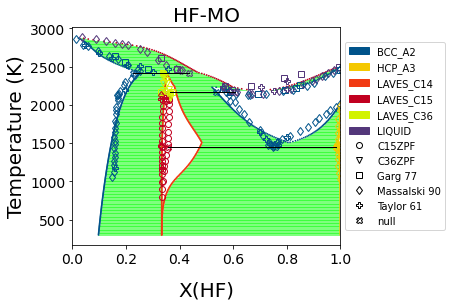

In [10]:
import yaml
from espei import run_espei
from pycalphad import Database, binplot, equilibrium, variables as v
from espei.datasets import load_datasets, recursive_glob
from espei.plot import dataplot
import matplotlib.pyplot as plt
# starting TDB after parameter selection
comps = ['HF', 'MO', 'VA']
phases = ['LIQUID', 'BCC_A2', 'HCP_A3', 'LAVES_C15', 'LAVES_C14', 'LAVES_C36']
#phases = list(dbf.phases.keys())
print(phases)
conds = {v.N: 1.0, v.P: 101325, v.T: (300, 3000, 10), v.X('HF'): (0, 1, 0.01)}
dbf = Database('mcmc_2.tdb') # database after running 300 iterations MCMC 
ax = binplot(dbf, comps, phases, conds)
datasets = load_datasets(recursive_glob('input_data/ZPF', '*.json'))
dataplot(comps, phases, conds, datasets, ax=ax)


The key output from the sampler are the trace (`emcee` calls this the "chain") and the log-probability (lnprob). The trace has the shape `(number of chains, number of iterations, number of parameters)`. The log-probability has the shape  `(number of chains, number of iterations)`.



In [6]:
trace = sampler.chain
lnprob = sampler.lnprobability

print(f"Trace shape:           {trace.shape}")
print(f"Log-probability shape: {lnprob.shape}")

Trace shape:           (38, 5, 19)
Log-probability shape: (38, 5)


### Simulated MCMC analysis
Typically, a fully converged MCMC simulation with enough samples to do uncertainty quantification will require a few hundred to a few thousand calculations. 

In [45]:
import numpy as np
from espei.analysis import truncate_arrays

In [48]:
trace = np.load('trace100.npy')
lnprob = np.load('prob100.npy')

trace, lnprob = truncate_arrays(trace, lnprob)

In [49]:
print(lnprob)

[[-2224147.94262187 -2224147.94262187 -1021538.81924606 ...
   -136110.76169335  -136089.69130457  -136069.27286929]
 [ -599140.87915568  -489053.43474891  -489053.43474891 ...
   -140008.69214543  -140008.69214543  -140008.69214543]
 [-1010935.11146533 -1010935.11146533 -1010935.11146533 ...
   -137203.91545905  -137203.91545905  -137203.91545905]
 ...
 [-1288334.65447263  -543723.04887255  -543723.04887255 ...
   -137700.73330635  -136103.99159961  -136103.99159961]
 [-1984320.86634739 -1984320.86634739 -1984320.86634739 ...
   -143592.6379586   -143366.13088143  -138006.83464298]
 [ -664925.75466973  -664925.75466973  -664925.75466973 ...
   -143069.15903542  -140373.40735012  -139362.43557934]]


#### Visualizing convergence of the simulation

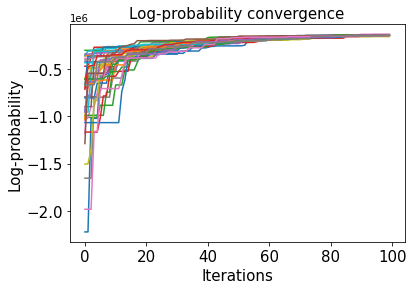

In [21]:
import matplotlib.pyplot as plt
plt.plot(lnprob.T)
plt.title('Log-probability convergence',fontsize=15)
plt.xlabel('Iterations',fontsize=15)
plt.ylabel('Log-probability',fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
#plt.figure()
#plt.ylim(-4000, -2000)
#plt.savefig('lnprob.png',dpi=300, bbox_inches='tight', pad_inches=0.1)

#### Visualizing change in a particular parameter

Text(0.5, 1.0, 'Parameter Convergence')

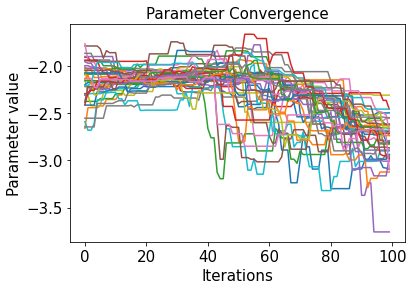

In [22]:
# index of parameter of interest within the chain
# could be looped to produce figures for all parameters
parameter_idx = 5

num_chains = trace.shape[0]
ax = plt.figure().gca()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Iterations',fontsize=15)
ax.set_ylabel('Parameter value',fontsize=15)
ax.plot(trace[..., parameter_idx].T)
ax.set_title('Parameter Convergence',fontsize=15)
#plt.savefig('trace.png',dpi=300, bbox_inches='tight', pad_inches=0.1)